In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision

# Define the Generator and Discriminator Newtorks

In [2]:
# All networks should inherit `nn.Module`
class Generator(nn.Module):
    """
    Takes a 100 element input vector and transforms
    it into an image with dimensions 64x64
    
    input is bacth_size x n_ch x width x height.
    In this case, (batch_size, 100, 1, 1)
    """
    
    # Note on convolutional transpose operations:
    # Input: (batch, chs_in, h_in, w_in)
    # Output: (batch, chs_out, h_out, w_out)
    # h_out = (h_in-1) * stride - 2 * padding + kernel
    
    # Anything with optimizable parameters needs to be
    # setup within the init method
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # Hidden Layer 1
            nn.ConvTranspose2d(in_channels=100, 
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            # Hidden Layer 2
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            # Hidden Layer 3
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            
            # Hidden Layer 4
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            
            # Output Layer
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )
        
    # All modules must override `forward`
    def forward(self, x):
        x = self.main(x)
        return x

In [3]:
class Discriminator(nn.Module):
    """
    Takes in a 32x32 image and produces a decision
    about if that image is genuine or generated.
    
    Input is (bacth_size x n_ch x width x height)
    In this case (100, 1, 64, 64)
    """
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # input is 1ch x 64w x 64h
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.main = nn.Sequential(
            
            # (batch_size, 1, 64, 64)
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1, 
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 64, 32, 32)
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 128, 16, 16)
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 256, 8, 8)
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            
            # (batch_size, 512, 4, 4)
            nn.Conv2d(in_channels=512,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            
            # (batch_size, 1, 1, 1)
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        x = self.main(x)
        return x

In [4]:
# Confirm the generator creates an image when given noise
# Map from (batch, 100, 1, 1) to (batch, 1, 32, 32)
G = Generator()
G(torch.randn(12, 100, 1, 1)).shape

torch.Size([12, 1, 64, 64])

In [5]:
# Confirm the discriminator produces a ruling given an image
# Map from (batch, 1, 64, 64) to (batch, 1, 1, 1)
D = Discriminator()
D(torch.randn(14, 1, 64, 64)).shape

torch.Size([14, 1, 1, 1])

# Prepare Data
### Note: All images are of size 64 x 86

In [6]:
def build_data_loader(batch_size):
    dataset = torchvision.datasets.ImageFolder(
        root='xray-hand-small',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(64), # Make smallest dimension 32
            torchvision.transforms.CenterCrop(64), # Cut to square image
            torchvision.transforms.Grayscale(), # Convert to grayscale
            torchvision.transforms.ToTensor(), # Transform from PIL image to Tensor
        ]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [7]:
# Utility methods for displaying data during training
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images):
    img = torchvision.utils.make_grid(images, normalize=True)
    npy_img = img.numpy()
    plt.imshow(np.transpose(npy_img, (1, 2, 0)),
               interpolation='nearest')
    plt.show()

torch.Size([8, 1, 64, 64])


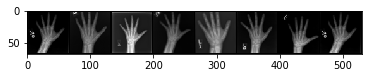

In [8]:
# Test on one a handful of images
# ...<rimshot.wav> :P
for data, _ in build_data_loader(8):
    test_images = data
    break
    
print(test_images.shape)
show_images(test_images)

# Perform Training

In [9]:
# Choose a loss function. Binary Cross Entropy Loss.
compute_loss = nn.BCELoss()

In [10]:
# Specify training details
n_epochs = 100
batch_size = 100

In [11]:
# Move everything to the GPU for training
gpu = torch.device(0)
G = G.to(gpu)
D = D.to(gpu)

In [12]:
# Create an optimizer to update the weights of each network
optimizer_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
data_loader = build_data_loader(batch_size)
test_noise = torch.randn((8, 100, 1, 1)).to(gpu)

Epoch: 0/100
Example images:


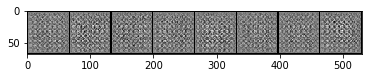

Epoch: 0	Batch: 128/129
Loss G: 3.94516921043396
Loss D: 0.4926135838031769
Epoch: 1/100
Example images:


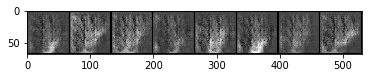

Epoch: 1	Batch: 128/129
Loss G: 3.0632357597351074
Loss D: 0.5526086091995239
Epoch: 2/100
Example images:


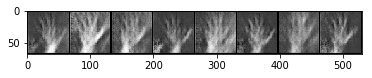

Epoch: 2	Batch: 128/129
Loss G: 3.1456851959228516
Loss D: 0.3833920657634735
Epoch: 3/100
Example images:


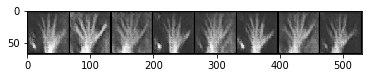

Epoch: 3	Batch: 128/129
Loss G: 3.280810832977295
Loss D: 0.6306593418121338
Epoch: 4/100
Example images:


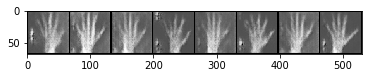

Epoch: 4	Batch: 128/129
Loss G: 3.055230140686035
Loss D: 0.4620433449745178
Epoch: 5/100
Example images:


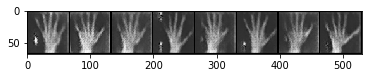

Epoch: 5	Batch: 128/129
Loss G: 4.252257347106934
Loss D: 0.619860827922821
Epoch: 6/100
Example images:


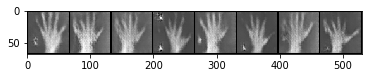

Epoch: 6	Batch: 128/129
Loss G: 1.419285535812378
Loss D: 1.0245518684387207
Epoch: 7/100
Example images:


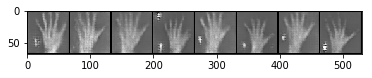

Epoch: 7	Batch: 128/129
Loss G: 3.7172341346740723
Loss D: 0.649782657623291
Epoch: 8/100
Example images:


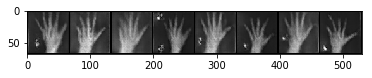

Epoch: 8	Batch: 128/129
Loss G: 6.464200496673584
Loss D: 1.1407725811004639
Epoch: 9/100
Example images:


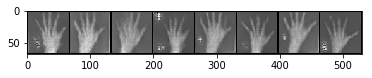

Epoch: 9	Batch: 128/129
Loss G: 1.3396079540252686
Loss D: 0.9246113300323486
Epoch: 10/100
Example images:


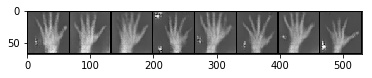

Epoch: 10	Batch: 128/129
Loss G: 0.8200352191925049
Loss D: 0.8729796409606934
Epoch: 11/100
Example images:


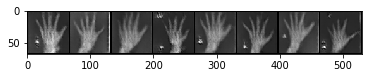

Epoch: 11	Batch: 128/129
Loss G: 2.5819251537323
Loss D: 0.5900198817253113
Epoch: 12/100
Example images:


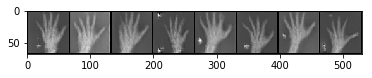

Epoch: 12	Batch: 128/129
Loss G: 2.145277976989746
Loss D: 0.578097939491272
Epoch: 13/100
Example images:


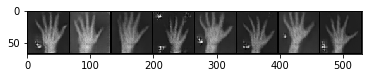

Epoch: 13	Batch: 128/129
Loss G: 2.714586019515991
Loss D: 0.3543016314506531
Epoch: 14/100
Example images:


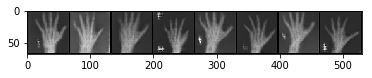

Epoch: 14	Batch: 128/129
Loss G: 2.7347629070281982
Loss D: 0.4472377598285675
Epoch: 15/100
Example images:


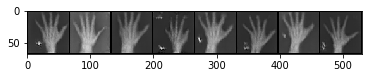

Epoch: 15	Batch: 128/129
Loss G: 3.3170642852783203
Loss D: 0.4554966688156128
Epoch: 16/100
Example images:


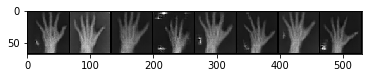

Epoch: 16	Batch: 128/129
Loss G: 3.1502861976623535
Loss D: 0.3469655513763428
Epoch: 17/100
Example images:


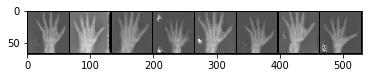

Epoch: 17	Batch: 128/129
Loss G: 2.9188075065612793
Loss D: 0.5122618675231934
Epoch: 18/100
Example images:


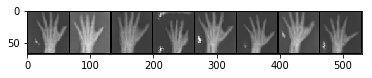

Epoch: 18	Batch: 128/129
Loss G: 3.6294541358947754
Loss D: 0.3004143238067627
Epoch: 19/100
Example images:


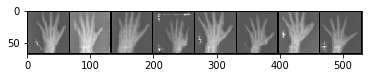

Epoch: 19	Batch: 128/129
Loss G: 3.00778865814209
Loss D: 0.3283016085624695
Epoch: 20/100
Example images:


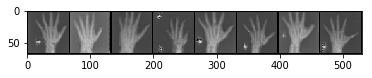

Epoch: 20	Batch: 128/129
Loss G: 3.8014907836914062
Loss D: 1.086592674255371
Epoch: 21/100
Example images:


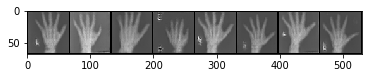

Epoch: 21	Batch: 128/129
Loss G: 3.7900986671447754
Loss D: 0.32821571826934814
Epoch: 22/100
Example images:


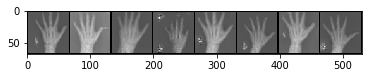

Epoch: 22	Batch: 128/129
Loss G: 4.945115089416504
Loss D: 0.26821258664131165
Epoch: 23/100
Example images:


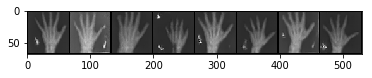

Epoch: 23	Batch: 128/129
Loss G: 3.364107608795166
Loss D: 0.09181459248065948
Epoch: 24/100
Example images:


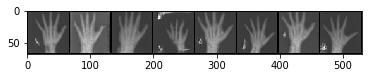

Epoch: 24	Batch: 128/129
Loss G: 4.263161659240723
Loss D: 0.20909380912780762
Epoch: 25/100
Example images:


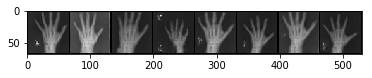

Epoch: 25	Batch: 128/129
Loss G: 4.263613224029541
Loss D: 0.1657404601573944
Epoch: 26/100
Example images:


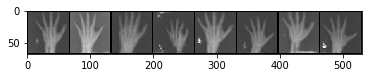

Epoch: 26	Batch: 128/129
Loss G: 4.270662307739258
Loss D: 0.22020211815834045
Epoch: 27/100
Example images:


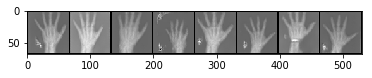

Epoch: 27	Batch: 128/129
Loss G: 4.613272666931152
Loss D: 0.22400307655334473
Epoch: 28/100
Example images:


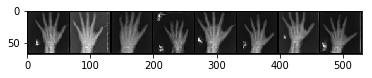

Epoch: 28	Batch: 128/129
Loss G: 5.286043643951416
Loss D: 0.2523729205131531
Epoch: 29/100
Example images:


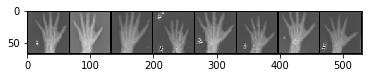

Epoch: 29	Batch: 128/129
Loss G: 5.68035888671875
Loss D: 0.16733747720718384
Epoch: 30/100
Example images:


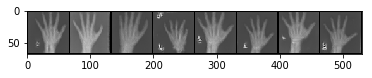

Epoch: 30	Batch: 128/129
Loss G: 5.490326881408691
Loss D: 0.14772702753543854
Epoch: 31/100
Example images:


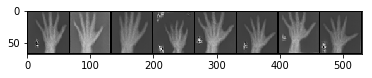

Epoch: 31	Batch: 128/129
Loss G: 4.60004997253418
Loss D: 0.12662051618099213
Epoch: 32/100
Example images:


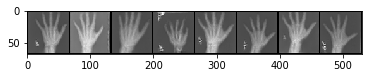

Epoch: 32	Batch: 128/129
Loss G: 4.90788459777832
Loss D: 0.0757453516125679
Epoch: 33/100
Example images:


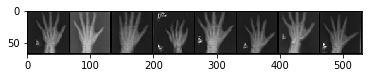

Epoch: 33	Batch: 128/129
Loss G: 4.821079254150391
Loss D: 0.11526608467102051
Epoch: 34/100
Example images:


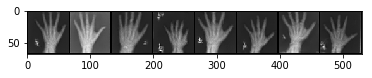

Epoch: 34	Batch: 128/129
Loss G: 5.883607864379883
Loss D: 0.3684127926826477
Epoch: 35/100
Example images:


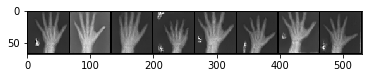

Epoch: 35	Batch: 128/129
Loss G: 3.7179880142211914
Loss D: 0.09711448848247528
Epoch: 36/100
Example images:


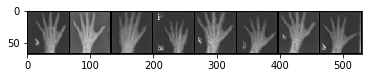

Epoch: 36	Batch: 128/129
Loss G: 6.693637847900391
Loss D: 0.4538704454898834
Epoch: 37/100
Example images:


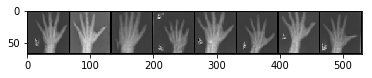

Epoch: 37	Batch: 128/129
Loss G: 7.707784652709961
Loss D: 0.45255160331726074
Epoch: 38/100
Example images:


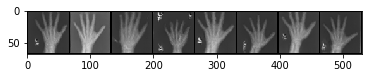

Epoch: 38	Batch: 128/129
Loss G: 5.724404335021973
Loss D: 0.2177860289812088
Epoch: 39/100
Example images:


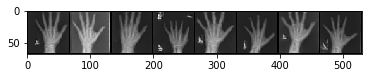

Epoch: 39	Batch: 128/129
Loss G: 4.8759942054748535
Loss D: 0.11269798874855042
Epoch: 40/100
Example images:


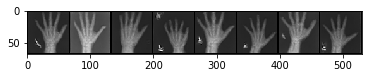

Epoch: 40	Batch: 128/129
Loss G: 4.843064785003662
Loss D: 0.11434735357761383
Epoch: 41/100
Example images:


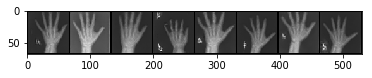

Epoch: 41	Batch: 128/129
Loss G: 5.02523136138916
Loss D: 0.31152966618537903
Epoch: 42/100
Example images:


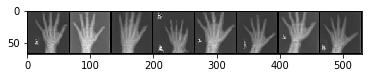

Epoch: 42	Batch: 128/129
Loss G: 5.079397678375244
Loss D: 0.039653949439525604
Epoch: 43/100
Example images:


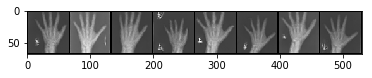

Epoch: 43	Batch: 128/129
Loss G: 4.804129600524902
Loss D: 0.09353023767471313
Epoch: 44/100
Example images:


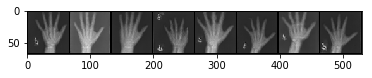

Epoch: 44	Batch: 128/129
Loss G: 4.882122993469238
Loss D: 0.1570442169904709
Epoch: 45/100
Example images:


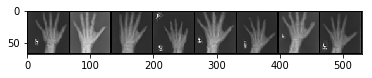

Epoch: 45	Batch: 128/129
Loss G: 6.5733442306518555
Loss D: 0.2601950466632843
Epoch: 46/100
Example images:


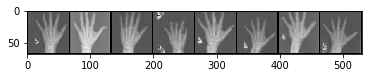

Epoch: 46	Batch: 128/129
Loss G: 9.781450271606445
Loss D: 0.3651043474674225
Epoch: 47/100
Example images:


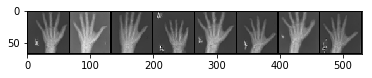

Epoch: 47	Batch: 128/129
Loss G: 5.05800724029541
Loss D: 0.09656251966953278
Epoch: 48/100
Example images:


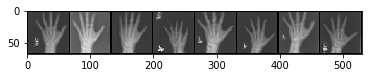

Epoch: 48	Batch: 128/129
Loss G: 9.558659553527832
Loss D: 0.6470084190368652
Epoch: 49/100
Example images:


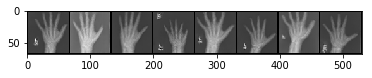

Epoch: 49	Batch: 128/129
Loss G: 9.206330299377441
Loss D: 0.6021942496299744
Epoch: 50/100
Example images:


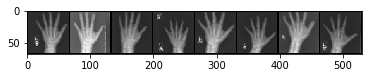

Epoch: 50	Batch: 128/129
Loss G: 5.197513103485107
Loss D: 0.19101303815841675
Epoch: 51/100
Example images:


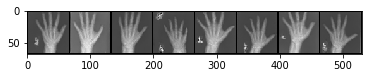

Epoch: 51	Batch: 128/129
Loss G: 5.934564590454102
Loss D: 0.17512090504169464
Epoch: 52/100
Example images:


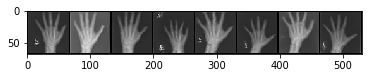

Epoch: 52	Batch: 128/129
Loss G: 3.982205867767334
Loss D: 0.0781533271074295
Epoch: 53/100
Example images:


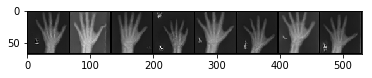

Epoch: 53	Batch: 128/129
Loss G: 4.308796405792236
Loss D: 0.1614638864994049
Epoch: 54/100
Example images:


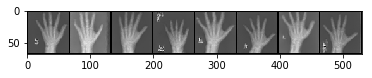

Epoch: 54	Batch: 128/129
Loss G: 4.092382431030273
Loss D: 0.095731720328331
Epoch: 55/100
Example images:


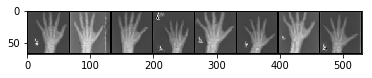

Epoch: 55	Batch: 128/129
Loss G: 5.497402191162109
Loss D: 0.10722293704748154
Epoch: 56/100
Example images:


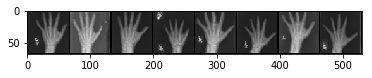

Epoch: 56	Batch: 128/129
Loss G: 4.795703887939453
Loss D: 0.1942298710346222
Epoch: 57/100
Example images:


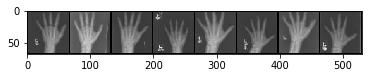

Epoch: 57	Batch: 128/129
Loss G: 6.298112869262695
Loss D: 0.034655384719371796
Epoch: 58/100
Example images:


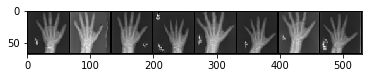

Epoch: 58	Batch: 128/129
Loss G: 5.192482948303223
Loss D: 0.17147111892700195
Epoch: 59/100
Example images:


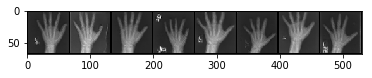

Epoch: 59	Batch: 128/129
Loss G: 5.1738080978393555
Loss D: 0.10033192485570908
Epoch: 60/100
Example images:


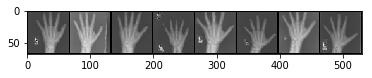

Epoch: 60	Batch: 128/129
Loss G: 5.040807723999023
Loss D: 0.08108750730752945
Epoch: 61/100
Example images:


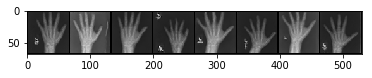

Epoch: 61	Batch: 128/129
Loss G: 5.6109466552734375
Loss D: 0.04703016206622124
Epoch: 62/100
Example images:


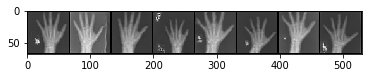

Epoch: 62	Batch: 128/129
Loss G: 5.817448616027832
Loss D: 0.0977141484618187
Epoch: 63/100
Example images:


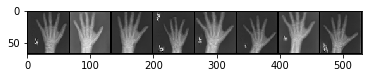

Epoch: 63	Batch: 128/129
Loss G: 5.847071170806885
Loss D: 0.1093498021364212
Epoch: 64/100
Example images:


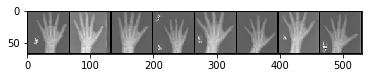

Epoch: 64	Batch: 128/129
Loss G: 7.197806358337402
Loss D: 0.20347453653812408
Epoch: 65/100
Example images:


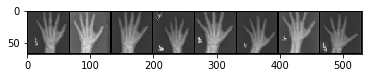

Epoch: 65	Batch: 128/129
Loss G: 5.283906936645508
Loss D: 0.11480653285980225
Epoch: 66/100
Example images:


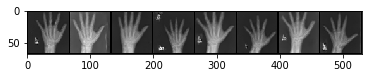

Epoch: 66	Batch: 128/129
Loss G: 5.409511566162109
Loss D: 0.11931232362985611
Epoch: 67/100
Example images:


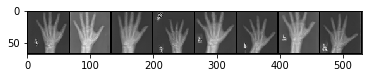

Epoch: 67	Batch: 128/129
Loss G: 4.973217487335205
Loss D: 0.08185451477766037
Epoch: 68/100
Example images:


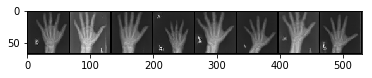

Epoch: 68	Batch: 128/129
Loss G: 5.687678337097168
Loss D: 0.026627596467733383
Epoch: 69/100
Example images:


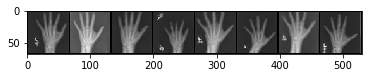

Epoch: 69	Batch: 128/129
Loss G: 6.412332534790039
Loss D: 0.03366585075855255
Epoch: 70/100
Example images:


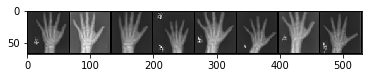

Epoch: 70	Batch: 128/129
Loss G: 4.862973213195801
Loss D: 0.05922627076506615
Epoch: 71/100
Example images:


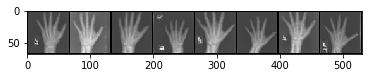

Epoch: 71	Batch: 128/129
Loss G: 4.507920265197754
Loss D: 0.04112390801310539
Epoch: 72/100
Example images:


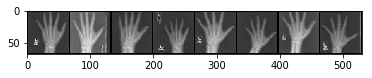

Epoch: 72	Batch: 128/129
Loss G: 5.504598617553711
Loss D: 0.08785687386989594
Epoch: 73/100
Example images:


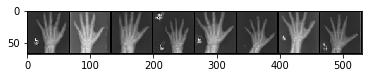

Epoch: 73	Batch: 128/129
Loss G: 5.8496270179748535
Loss D: 0.11031598597764969
Epoch: 74/100
Example images:


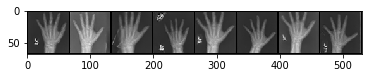

Epoch: 74	Batch: 128/129
Loss G: 9.648336410522461
Loss D: 0.4375406801700592
Epoch: 75/100
Example images:


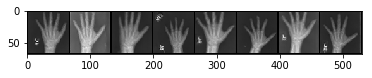

Epoch: 75	Batch: 128/129
Loss G: 5.6758527755737305
Loss D: 0.04540516436100006
Epoch: 76/100
Example images:


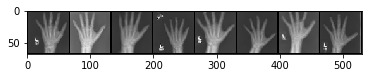

Epoch: 76	Batch: 128/129
Loss G: 5.209321975708008
Loss D: 0.08635863661766052
Epoch: 77/100
Example images:


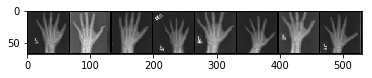

Epoch: 77	Batch: 128/129
Loss G: 4.587767601013184
Loss D: 0.06807062029838562
Epoch: 78/100
Example images:


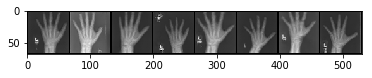

Epoch: 78	Batch: 128/129
Loss G: 5.282427787780762
Loss D: 0.14827334880828857
Epoch: 79/100
Example images:


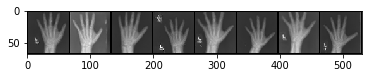

Epoch: 79	Batch: 128/129
Loss G: 5.667366981506348
Loss D: 0.03526987135410309
Epoch: 80/100
Example images:


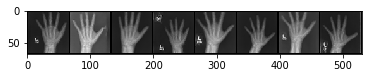

Epoch: 80	Batch: 128/129
Loss G: 4.854713439941406
Loss D: 0.06369662284851074
Epoch: 81/100
Example images:


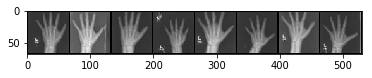

Epoch: 81	Batch: 128/129
Loss G: 5.110021591186523
Loss D: 0.024439334869384766
Epoch: 82/100
Example images:


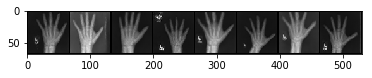

Epoch: 82	Batch: 128/129
Loss G: 6.013056755065918
Loss D: 0.05111381411552429
Epoch: 83/100
Example images:


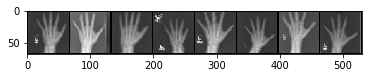

Epoch: 83	Batch: 128/129
Loss G: 6.2858147621154785
Loss D: 0.06330796331167221
Epoch: 84/100
Example images:


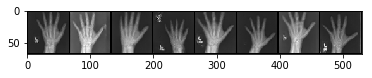

Epoch: 84	Batch: 128/129
Loss G: 8.559453964233398
Loss D: 0.23896920680999756
Epoch: 85/100
Example images:


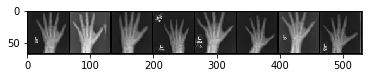

Epoch: 85	Batch: 128/129
Loss G: 4.691347122192383
Loss D: 0.03422661870718002
Epoch: 86/100
Example images:


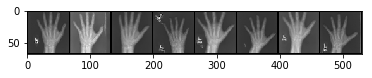

Epoch: 86	Batch: 128/129
Loss G: 6.6882734298706055
Loss D: 0.11843971163034439
Epoch: 87/100
Example images:


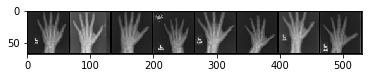

Epoch: 87	Batch: 128/129
Loss G: 5.033468246459961
Loss D: 0.1151733547449112
Epoch: 88/100
Example images:


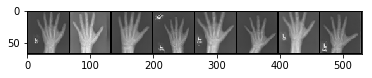

Epoch: 88	Batch: 128/129
Loss G: 5.694173812866211
Loss D: 0.028681959956884384
Epoch: 89/100
Example images:


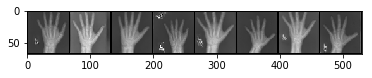

Epoch: 89	Batch: 128/129
Loss G: 5.333808898925781
Loss D: 0.06319446861743927
Epoch: 90/100
Example images:


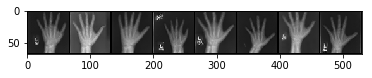

Epoch: 90	Batch: 128/129
Loss G: 5.1319122314453125
Loss D: 0.045720018446445465
Epoch: 91/100
Example images:


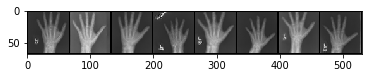

Epoch: 91	Batch: 128/129
Loss G: 5.990700721740723
Loss D: 0.03791550546884537
Epoch: 92/100
Example images:


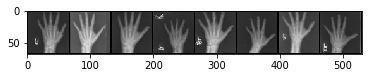

Epoch: 92	Batch: 128/129
Loss G: 5.632939338684082
Loss D: 0.060973092913627625
Epoch: 93/100
Example images:


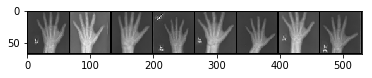

Epoch: 93	Batch: 128/129
Loss G: 6.6200761795043945
Loss D: 0.03437226265668869
Epoch: 94/100
Example images:


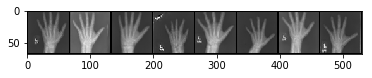

Epoch: 94	Batch: 128/129
Loss G: 4.874790191650391
Loss D: 0.026454560458660126
Epoch: 95/100
Example images:


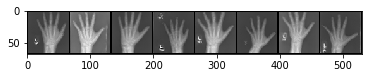

Epoch: 95	Batch: 128/129
Loss G: 5.16013240814209
Loss D: 0.03532745689153671
Epoch: 96/100
Example images:


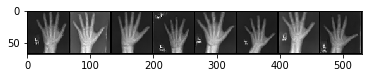

Epoch: 96	Batch: 128/129
Loss G: 4.530788898468018
Loss D: 0.046337950974702835
Epoch: 97/100
Example images:


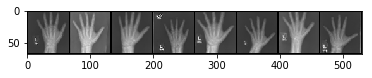

Epoch: 97	Batch: 128/129
Loss G: 7.199640274047852
Loss D: 0.1446118950843811
Epoch: 98/100
Example images:


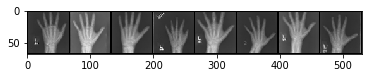

Epoch: 98	Batch: 128/129
Loss G: 5.173727989196777
Loss D: 0.05094752088189125
Epoch: 99/100
Example images:


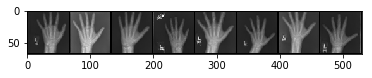

Epoch: 99	Batch: 128/129
Loss G: 5.468626976013184
Loss D: 0.03774663805961609


In [14]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch}/{n_epochs}")
    print("Example images:")
    generated_images = G(test_noise).detach().cpu()
    show_images(generated_images)
    
    for i, (batch, _) in enumerate(data_loader):
        print(f"\rEpoch: {epoch}\tBatch: {i}/{len(data_loader)}", end='')
        ## Train the discriminiator ##
        D.zero_grad()

        # Compute error on real data
        real = Variable(batch).to(gpu)
        real_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        real_predictions = D(real)
        d_error_real = compute_loss(real_predictions, real_labels)
        
        # Compute error on fake data
        noise = Variable(torch.randn(real.size(0), 100, 1, 1)).to(gpu)
        fake = G(noise)
        fake_predictions = D(fake.detach())
        fake_labels = Variable(torch.zeros(real.size(0), 1, 1, 1)).to(gpu)
        d_error_fake = compute_loss(fake_predictions, fake_labels)
        
        # Accumulate and backpropogate on combined error
        d_error_total = d_error_real + d_error_fake
        d_error_total.backward()
        optimizer_d.step()
        
        ## Train the generator ##
        G.zero_grad()
        
        # Compute rate of fakes being detected
        goal_labels = Variable(torch.ones(real.size(0), 1, 1, 1)).to(gpu)
        results = D(fake)
        g_error = compute_loss(results, goal_labels)
        
        # Backpropogate and update weights
        g_error.backward()
        optimizer_g.step()
    
    print("")
    print(f"Loss G: {g_error}")
    print(f"Loss D: {d_error_total}")

In [16]:
torch.save(G.state_dict(), "trained_generator")
torch.save(D.state_dict(), "trained_discriminator")